# 1. Training of Surrogate Models

In [9]:
import os
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.optimize import differential_evolution

TRAIN_DIR = "train_data"

X_tr  = np.load(os.path.join(TRAIN_DIR, "X.npy")).astype(float)
yV_tr = np.load(os.path.join(TRAIN_DIR, "y_viscosity.npy")).astype(float)
yE_tr = np.load(os.path.join(TRAIN_DIR, "y_elongation.npy")).astype(float)
yM_tr = np.load(os.path.join(TRAIN_DIR, "y_modulus.npy")).astype(float)
yR_tr = np.load(os.path.join(TRAIN_DIR, "y_reactiontime.npy")).astype(float)

# to fraction
rs = X_tr.sum(axis=1)
if np.allclose(rs, 100.0, atol=1e-6):
    X_tr = X_tr / 10.0
elif np.allclose(rs, 1.0, atol=1e-6):
    X_tr = X_tr * 10.0

# normalization
yV_tr_log = np.log1p(yV_tr)
yE_tr_log = np.log1p(yE_tr)
yM_tr_log = np.log1p(yM_tr)
yR_tr_log = np.log1p(yR_tr)

visc_model = SVR(kernel='rbf', C=100,  gamma=0.1,  epsilon=0.01)
elon_model = SVR(kernel='rbf', C=400,  gamma=0.01, epsilon=0.01)
mod_model  = SVR(kernel='rbf', C=1000, gamma=0.7,  epsilon=0.05)
rt_model   = SVR(kernel='rbf', C=100,  gamma=0.1,  epsilon=0.01)

visc_model.fit(X_tr, yV_tr_log)
elon_model.fit(X_tr, yE_tr_log)
mod_model.fit(X_tr, yM_tr_log)
rt_model.fit(X_tr, yR_tr_log);

# 2. Validation of Results

Train metrics (raw R² | log RMSE)
Viscosity     : 1.000 | 0.012
Elongation    : 0.810 | 0.553
Modulus       : 0.996 | 0.050
Reaction Time : 0.999 | 0.017


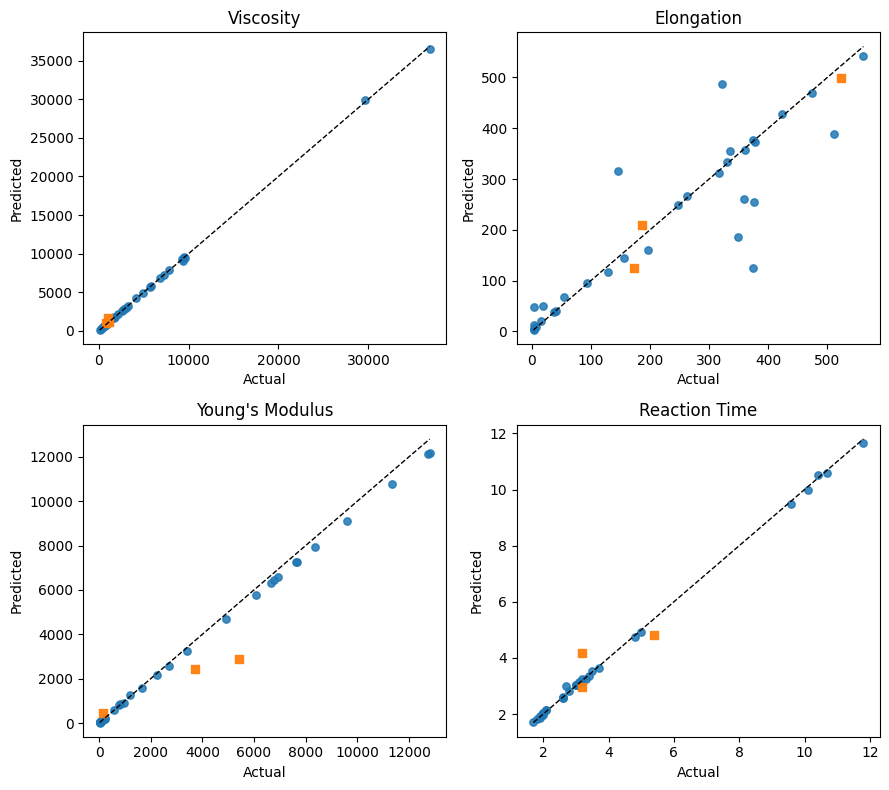

In [10]:
VAL_DIR = "val_data"

X_val  = np.load(os.path.join(VAL_DIR, "X.npy")).astype(float)
yV_val = np.load(os.path.join(VAL_DIR, "y_viscosity.npy")).astype(float)
yE_val = np.load(os.path.join(VAL_DIR, "y_elongation.npy")).astype(float)
yM_val = np.load(os.path.join(VAL_DIR, "y_modulus.npy")).astype(float)
yR_val = np.load(os.path.join(VAL_DIR, "y_reactiontime.npy")).astype(float)

# Normalize val inputs to parts-of-10
rs_val = X_val.sum(axis=1)
if np.allclose(rs_val, 100.0, atol=1e-6):
    X_val = X_val / 10.0
elif np.allclose(rs_val, 1.0, atol=1e-6):
    X_val = X_val * 10.0

# Predictions (train + val), back-transform
yV_hat_tr  = np.expm1(visc_model.predict(X_tr))
yE_hat_tr  = np.expm1(elon_model.predict(X_tr))
yM_hat_tr  = np.expm1(mod_model.predict(X_tr))
yR_hat_tr  = np.expm1(rt_model.predict(X_tr))

yV_hat_val = np.expm1(visc_model.predict(X_val))
yE_hat_val = np.expm1(elon_model.predict(X_val))
yM_hat_val = np.expm1(mod_model.predict(X_val))
yR_hat_val = np.expm1(rt_model.predict(X_val))

print("Train metrics (raw R² | log RMSE)")
print("Viscosity     :", f"{r2_score(yV_tr, yV_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yV_tr), np.log1p(yV_hat_tr)):.3f}")
print("Elongation    :", f"{r2_score(yE_tr, yE_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yE_tr), np.log1p(yE_hat_tr)):.3f}")
print("Modulus       :", f"{r2_score(yM_tr, yM_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yM_tr), np.log1p(yM_hat_tr)):.3f}")
print("Reaction Time :", f"{r2_score(yR_tr, yR_hat_tr):.3f}", "|", f"{root_mean_squared_error(np.log1p(yR_tr), np.log1p(yR_hat_tr)):.3f}")

# visualization
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
pairs = [
    ("Viscosity",     yV_tr, yV_hat_tr, yV_val, yV_hat_val, axes[0,0]),
    ("Elongation",    yE_tr, yE_hat_tr, yE_val, yE_hat_val, axes[0,1]),
    ("Young's Modulus", yM_tr, yM_hat_tr, yM_val, yM_hat_val, axes[1,0]),
    ("Reaction Time", yR_tr, yR_hat_tr, yR_val, yR_hat_val, axes[1,1]),
]
for title, yt_tr, yp_tr, yt_va, yp_va, ax in pairs:
    lb = float(min(yt_tr.min(), yt_va.min(), yp_tr.min(), yp_va.min()))
    ub = float(max(yt_tr.max(), yt_va.max(), yp_tr.max(), yp_va.max()))
    ax.plot([lb, ub], [lb, ub], "k--", linewidth=1)
    ax.scatter(yt_tr, yp_tr, s=28, alpha=0.85, label="Train")
    ax.scatter(yt_va, yp_va, s=36, alpha=0.95, marker="s", label="Val")
    ax.set_title(title)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
plt.tight_layout()
plt.show()

# 3. Optimization (Differential Evolution)

In [15]:
# objective weights (empirically tuned)
wE, wM, wV, wR = 28.0, 32.0, 0.7, 1.4

# constraints for optimization
bounds = [(4.0, 5.0), (3.0, 5.0), (0.2, 5.0), (0.4, 1.0)]
penalty_weight = 1e6 

objective = lambda x: (
    -(
        wE * np.expm1(elon_model.predict(np.asarray(x, float).reshape(1,-1)).item()) -
        wM * np.expm1(mod_model.predict (np.asarray(x, float).reshape(1,-1)).item()) -
        wV * np.expm1(visc_model.predict(np.asarray(x, float).reshape(1,-1)).item()) -
        wR * np.expm1(rt_model.predict  (np.asarray(x, float).reshape(1,-1)).item())
     )
    + penalty_weight * (np.sum(np.asarray(x, float)) - 10.0)**2
)

result = differential_evolution(
    objective,
    bounds=bounds,
    maxiter=120,
    popsize=20,
    seed=42,
    disp=False,
    polish=True
)

x_best = result.x
print("Optimal parts (PUDA, IBOA, EHMA, MAA):", x_best)

Optimal parts (PUDA, IBOA, EHMA, MAA): [5.         3.         1.60474995 0.4       ]


In [3]:
import numpy as np
from scipy.optimize import differential_evolution

# Suppose your trained models are:
#   visc_model  -> predicts log(1 + Viscosity)
#   elon_model  -> predicts log(1 + Elongation)
#   young_model -> predicts log(1 + Young's Modulus)
# and they are all globally defined or in scope.

# -------------------------------
# 1) Define the Weighted Objective
# -------------------------------
def surrogate_objective(x, wE=1.0, wM=1.0, wV=1.0):
    """
    x: array-like of shape [4, ] = [PUDA, IBOA, EHMA, MAA]
    wE, wM, wV: weights for Elongation, Modulus, Viscosity.

    We will define an objective that we want to *maximize*:
         F(x) = wE*E - wM*M - wV*V

    But SciPy's differential_evolution MINIMIZES a function,
    so we return -F(x) so that maximizing F is the same
    as minimizing -F.
    """
    # Reshape x for the model's "predict" method
    x_ = np.array(x).reshape(1, -1)  # shape (1,4)

    # 1) Predict log(1 + property)
    pred_log_vis = visc_model.predict(x_)[0]
    pred_log_elo = elon_model.predict(x_)[0]
    pred_log_mod = young_model.predict(x_)[0]

    # 2) Convert back from log(1 + y) => y
    viscosity   = np.expm1(pred_log_vis)
    elongation  = np.expm1(pred_log_elo)
    youngs_mod  = np.expm1(pred_log_mod)

    # 3) Weighted objective
    #    + for elongation, - for modulus & viscosity
    score = wE * elongation - wM * youngs_mod - wV * viscosity

    # 4) Since we want to maximize 'score' but the solver does minimization:
    return -score  # negative sign for maximizing

# -------------------------------
# 2) Define Bounds for Each Input
# -------------------------------
# You can define these bounds from your domain knowledge.
# For example, let's say each of PUDA, IBOA, EHMA, and MAA can vary from 0 to 6.
# Or you might have other constraints or sums that must be satisfied.
bounds = [
    (0.0, 8.0),  # PUDA
    (0.0, 6.0),  # IBOA
    (0.0, 6.0),  # EHMA
    (0.0, 6.0)   # MAA
]

# -------------------------------
# 3) Run the Optimization
# -------------------------------
# We choose some weights, for example:
wE = 3.0   # emphasize elongation
wM = 1.0   # normal emphasis on modulus
wV = 1.0   # normal emphasis on viscosity

result = differential_evolution(
    surrogate_objective,
    bounds=bounds,
    args=(wE, wM, wV),      # Pass in the weights as arguments
    maxiter=100,            # Number of generations
    popsize=15,             # Population size
    mutation=(0.5, 1.0),    # Mutation strategy
    recombination=0.7,      
    disp=True,              # Print progress
    polish=True,            # Local search at the end
    seed=42                 # For reproducibility
)

# -------------------------------
# 4) Inspect Results
# -------------------------------
print("Optimization success:", result.success)
print("Best input found:", result.x)
print("Best (negative) objective value:", result.fun)
print("Best (positive) objective value:", -result.fun)  # Because we returned -score

# If you want the predicted properties at that optimum:
best_x = result.x.reshape(1,-1)
best_vis = np.expm1(visc_model.predict(best_x))[0]
best_elo = np.expm1(elon_model.predict(best_x))[0]
best_mod = np.expm1(young_model.predict(best_x))[0]

print("Predicted Viscosity:",  best_vis)
print("Predicted Elongation:", best_elo)
print("Predicted Modulus:",    best_mod)


/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitte

differential_evolution step 1: f(x)= -5836.838345773549
differential_evolution step 2: f(x)= -6322.102507748441
differential_evolution step 3: f(x)= -6496.06938964302
differential_evolution step 4: f(x)= -6496.06938964302
differential_evolution step 5: f(x)= -11738.189055033283
differential_evolution step 6: f(x)= -11738.189055033283
differential_evolution step 7: f(x)= -14066.48736037012
differential_evolution step 8: f(x)= -14066.48736037012
differential_evolution step 9: f(x)= -16765.226495036808
differential_evolution step 10: f(x)= -16765.226495036808


/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitte

differential_evolution step 11: f(x)= -16765.226495036808
differential_evolution step 12: f(x)= -18816.610192825425
differential_evolution step 13: f(x)= -18816.610192825425
differential_evolution step 14: f(x)= -18816.610192825425
differential_evolution step 15: f(x)= -19186.96514554508
differential_evolution step 16: f(x)= -19186.96514554508


/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitte

differential_evolution step 17: f(x)= -20175.878722595462
differential_evolution step 18: f(x)= -20175.878722595462
differential_evolution step 19: f(x)= -20729.21574041349
differential_evolution step 20: f(x)= -20729.21574041349
differential_evolution step 21: f(x)= -21018.96694471472
differential_evolution step 22: f(x)= -21018.96694471472
differential_evolution step 23: f(x)= -21018.96694471472
differential_evolution step 24: f(x)= -21018.96694471472
differential_evolution step 25: f(x)= -21274.266854972342
differential_evolution step 26: f(x)= -21274.266854972342
differential_evolution step 27: f(x)= -21282.00564439592
differential_evolution step 28: f(x)= -21282.00564439592
differential_evolution step 29: f(x)= -21282.00564439592


/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitte

differential_evolution step 30: f(x)= -21282.00564439592
differential_evolution step 31: f(x)= -21282.00564439592
differential_evolution step 32: f(x)= -21313.623010775074
differential_evolution step 33: f(x)= -21313.623010775074
differential_evolution step 34: f(x)= -21386.484635051336
differential_evolution step 35: f(x)= -21386.484635051336
differential_evolution step 36: f(x)= -21386.484635051336
differential_evolution step 37: f(x)= -21386.484635051336
differential_evolution step 38: f(x)= -21432.807297789226
Polishing solution with 'L-BFGS-B'
Optimization success: True
Best input found: [3.58382859 6.         6.         0.        ]
Best (negative) objective value: -21509.326977065055
Best (positive) objective value: 21509.326977065055
Predicted Viscosity: 1278.2180170418617
Predicted Elongation: 7888.065254547167
Predicted Modulus: 876.650769534583


/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/bumsoo/.env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitte

In [84]:
tpuda = [2, 4, 5, 6, 8, 2, 4, 5, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3]
len(tpuda)

38

In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR

# Individual elements
puda = [2, 4, 5, 6, 8, 2, 4, 5, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3]
iboa = [4, 3, 2.5, 2, 1, 4, 3, 2.5, 2, 1, 4, 0, 0, 2, 2, 3, 3, 3, 2, 1, 5, 0, 0, 3, 2, 2.5, 1, 6, 0, 0, 4, 3, 2, 1, 5 , 4, 1.5, 1.5]
ehma = [4, 3, 2.5, 2, 1, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 1, 0.5, 1, 1.5, 0, 5, 0, 1, 1.5, 1.5, 2, 0, 6, 0, 1, 1.5, 2, 2.5, 1, 1.5, 2, 2.5]
maa = [0, 0, 0, 0, 0, 4, 3, 2.5, 2, 1, 0, 0, 4, 0, 2, 1, 0, 0.5, 1, 1.5, 0, 0, 5, 1, 1.5, 1, 2, 0, 0, 6, 1, 1.5, 2, 2.5, 1, 1.5, 2, 2.5]

# Create data frame
inDF = pd.DataFrame({
    "PUDA": puda,
    "IBOA": iboa,
    "EHMA": ehma,
    "MAA": maa
})

# Output data
output_data = {
    "Viscosity": [921.47, 1023.67, 2812.67, 7963.17, 29639.67, 113.47, 1130.67, 3291.17, 8041.17, 36824.67, 9574.17, 4958.17, 5819.17, 6594.67, 7539.67, 9506.17, 6808.17, 9232.67, 9425.67, 5693.17, 4179.67, 1730.67, 1827.67, 2990.67, 2580.67, 2673.17, 2175.17, 1743.17, 603.72, 681.07, 1186.17, 849.47, 950.22, 747.62, 442.40, 356.20, 339.80, 300.50],
    "Elongation": [377, 523, 474, 103, 40, 3.6, 4.47, 196, 330, 374, 336, 94.2, 4.2, 188, 247, 561, 511, 321, 424, 359, 316, 349, 4.03, 375, 376, 360, 156, 263, 247, 4.13, 186, 173, 54.8, 37.6, 129, 19.3, 15.8, 7.1],
    "YoungsModulus": [1675.00, 150.94, 52.08, 36.74, 44.18, 4923.08, 1182.61, 7625.00, 3420.29, 128.21, 142.86, 27.59, 9590.16, 34.29, 3486.49, 212.39, 86.54, 56.12, 232.56, 801.80, 760.87, 23.26, 11346.67, 973.68, 2259.26, 574.32, 12731.96, 2698.11, 26.32, 12804.88, 3725.00, 5436.36, 6921.05, 8344.26, 6083.33, 6645.83, 6767.44, 7651.52]
}

# Prepare the target for viscosity
y_viscosity = np.log1p(outDF['Viscosity'])

# Fit the model on the DataFrame
visc_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
visc_model.fit(inDF, y_viscosity)

# Repeat similarly for Elongation and Young's Modulus
y_elongation = np.log1p(outDF['Elongation'])
elon_model   = SVR(kernel='rbf', C=400, gamma=0.01, epsilon=0.01)
elon_model.fit(inDF, y_elongation)

y_youngs_modulus = np.log1p(outDF['YoungsModulus'])
young_model = SVR(kernel='rbf', C=1000, gamma=0.7, epsilon=0.05)
young_model.fit(inDF, y_youngs_modulus)


SVR(C=1000, epsilon=0.05, gamma=0.7)

In [5]:
def surrogate_objective(x, wE=1.0, wM=1.0, wV=1.0):
    """
    x: array-like of shape (4,)
       [PUDA, IBOA, EHMA, MAA]
    wE, wM, wV: Weights for Elongation, Modulus, Viscosity
    """
    # 1) Convert x into a 1-row DataFrame with the same columns
    x_df = pd.DataFrame([x], columns=["PUDA", "IBOA", "EHMA", "MAA"])

    # 2) Predict log(1 + property) using each model
    pred_log_vis = visc_model.predict(x_df)[0]
    pred_log_elo = elon_model.predict(x_df)[0]
    pred_log_mod = young_model.predict(x_df)[0]

    # 3) Convert from log(1 + y) back to y
    viscosity   = np.expm1(pred_log_vis)
    elongation  = np.expm1(pred_log_elo)
    youngs_mod  = np.expm1(pred_log_mod)

    # 4) Weighted objective: maximize Elongation, minimize Modulus, minimize Viscosity
    #    But differential_evolution, etc., usually *minimize* the returned value.
    #    So we define a "score" and return its negative.
    score = wE*elongation - wM*youngs_mod - wV*viscosity
    return -score  # negative => we are effectively maximizing 'score'

from scipy.optimize import differential_evolution

# Define the search bounds for each variable
bounds = [
    (0.0, 8.0),  # PUDA
    (0.0, 6.0),  # IBOA
    (0.0, 6.0),  # EHMA
    (0.0, 6.0)   # MAA
]

# Example weights, emphasizing elongation 3x more than the other properties
wE, wM, wV = 3.0, 1.0, 1.0

result = differential_evolution(
    surrogate_objective,
    bounds=bounds,
    args=(wE, wM, wV),
    maxiter=100,
    popsize=15,
    seed=42,
    disp=True,
    polish=True
)

print("Best input found:", result.x)
print("Objective value:", result.fun)  # This is the minimized value
print("Maximized 'score':", -result.fun)


differential_evolution step 1: f(x)= -5836.838345773549
differential_evolution step 2: f(x)= -6322.102507748441
differential_evolution step 3: f(x)= -6496.06938964302
differential_evolution step 4: f(x)= -6496.06938964302
differential_evolution step 5: f(x)= -11738.189055033283
differential_evolution step 6: f(x)= -11738.189055033283
differential_evolution step 7: f(x)= -14066.48736037012
differential_evolution step 8: f(x)= -14066.48736037012
differential_evolution step 9: f(x)= -16765.226495036808
differential_evolution step 10: f(x)= -16765.226495036808
differential_evolution step 11: f(x)= -16765.226495036808
differential_evolution step 12: f(x)= -18816.610192825425
differential_evolution step 13: f(x)= -18816.610192825425
differential_evolution step 14: f(x)= -18816.610192825425
differential_evolution step 15: f(x)= -19186.96514554508
differential_evolution step 16: f(x)= -19186.96514554508
differential_evolution step 17: f(x)= -20175.878722595462
differential_evolution step 18: f

In [37]:
best_x = result.x  # e.g. [PUDA_val, IBOA_val, EHMA_val, MAA_val]
best_df = pd.DataFrame([best_x], columns=["PUDA", "IBOA", "EHMA", "MAA"])

pred_log_vis = visc_model.predict(best_df)[0]
pred_log_elo = elon_model.predict(best_df)[0]
pred_log_mod = young_model.predict(best_df)[0]

best_vis = np.expm1(pred_log_vis)
best_elo = np.expm1(pred_log_elo)
best_mod = np.expm1(pred_log_mod)

print("Predicted Viscosity:",  best_vis)
print("Predicted Elongation:", best_elo)
print("Predicted Modulus:",    best_mod)


Predicted Viscosity: 1278.2180170418617
Predicted Elongation: 7888.065254547167
Predicted Modulus: 876.650769534583


In [40]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution

def surrogate_objective(x, wE=1.0, wM=1.0, wV=1.0, penalty_weight=1e5):
    """
    x: array of shape [4, ], i.e. [PUDA, IBOA, EHMA, MAA]
       must respect each range:
         PUDA: [3, 5]
         IBOA: [3, 5]
         EHMA: [0.2, 5]
         MAA:  [0.2, 1]
    wE, wM, wV: weights for Elongation, Modulus, Viscosity
    penalty_weight: how strongly we penalize any deviation from sum=10
    """

    # 1) Convert x into a 1-row DataFrame with correct columns
    x_df = pd.DataFrame([x], columns=["PUDA", "IBOA", "EHMA", "MAA"])

    # 2) Predict log(1 + property) using each model
    pred_log_vis = visc_model.predict(x_df)[0]
    pred_log_elo = elon_model.predict(x_df)[0]
    pred_log_mod = young_model.predict(x_df)[0]

    # 3) Convert from log(1 + y) -> y
    viscosity   = np.expm1(pred_log_vis)
    elongation  = np.expm1(pred_log_elo)
    youngs_mod  = np.expm1(pred_log_mod)

    # 4) Our desired "score": maximize Elongation, minimize Modulus & Viscosity
    #    But differential_evolution *minimizes* the returned value.
    score = wE*elongation - wM*youngs_mod - wV*viscosity

    # 5) Check the sum constraint
    sum_of_vars = x[0] + x[1] + x[2] + x[3]
    # If sum_of_vars == 10.0, no penalty; else add a big penalty
    penalty = (sum_of_vars - 10.0)**2   # squared difference
    penalty_term = penalty_weight * penalty

    # 6) The final "objective" for the solver is -(score) + penalty_term
    #    because we want to *maximize* `score`, so we minimize `-score`.
    return -score + penalty_term

# Bounds for each variable
bounds = [
    (3.0, 5.0),   # PUDA
    (3.0, 5.0),   # IBOA
    (0.2, 5.0),   # EHMA
    (0.2, 1.0)    # MAA
]

# Example weighting for the 3 properties
wE, wM, wV = 4.0, 1.5, 0.7

result = differential_evolution(
    surrogate_objective,
    bounds=bounds,
    args=(wE, wM, wV, 1e5),   # include penalty_weight in args
    maxiter=100,
    popsize=15,
    seed=42,
    disp=True
)

print("Optimization success:", result.success)
print("Best solution x:", result.x)
print("Objective value (minimized):", result.fun)
print("Maximized score (no penalty):", -result.fun)  # ignoring penalty, for interpretation

# -- Inspect predicted properties at the solution
x_df = pd.DataFrame([result.x], columns=["PUDA", "IBOA", "EHMA", "MAA"])
pred_log_vis = visc_model.predict(x_df)[0]
pred_log_elo = elon_model.predict(x_df)[0]
pred_log_mod = young_model.predict(x_df)[0]

print("Sum of variables:", sum(result.x))
print("Predicted Viscosity:", np.expm1(pred_log_vis))
print("Predicted Elongation:", np.expm1(pred_log_elo))
print("Predicted Modulus:", np.expm1(pred_log_mod))


differential_evolution step 1: f(x)= 1440.9944560473255
differential_evolution step 2: f(x)= 516.2552924761388
differential_evolution step 3: f(x)= 516.2552924761388
differential_evolution step 4: f(x)= -191.0511869824018
differential_evolution step 5: f(x)= -191.0511869824018
differential_evolution step 6: f(x)= -191.0511869824018
differential_evolution step 7: f(x)= -767.2646856208086
differential_evolution step 8: f(x)= -767.2646856208086
differential_evolution step 9: f(x)= -767.2646856208086
differential_evolution step 10: f(x)= -767.2646856208086
differential_evolution step 11: f(x)= -790.465449120847
differential_evolution step 12: f(x)= -790.465449120847
differential_evolution step 13: f(x)= -790.465449120847
differential_evolution step 14: f(x)= -790.465449120847
differential_evolution step 15: f(x)= -829.9104660160939
differential_evolution step 16: f(x)= -829.9104660160939
differential_evolution step 17: f(x)= -829.9104660160939
differential_evolution step 18: f(x)= -831.380

In [39]:
def reparam_objective(x, wE=1.0, wM=1.0, wV=1.0, penalty_weight=1e5):
    """
    x: array-like of shape (3,) = [PUDA, IBOA, EHMA]
    We define MAA = 10 - (PUDA + IBOA + EHMA).

    Must respect:
      3 <= PUDA <= 5
      3 <= IBOA <= 5
      0.2 <= EHMA <= 5
      0.2 <= MAA <= 1
      sum = 10 automatically
    """
    # Unpack
    puda, iboa, ehma = x
    maa = 10.0 - (puda + iboa + ehma)

    # Start with no penalty
    penalty = 0.0

    # Check each range constraint
    if not (3.0 <= puda <= 5.0):
        penalty += penalty_weight * (min(abs(puda - 3.0), abs(puda - 5.0)))
    if not (3.0 <= iboa <= 5.0):
        penalty += penalty_weight * (min(abs(iboa - 3.0), abs(iboa - 5.0)))
    if not (0.2 <= ehma <= 5.0):
        penalty += penalty_weight * (min(abs(ehma - 0.2), abs(ehma - 5.0)))
    if not (0.2 <= maa <= 1.0):
        penalty += penalty_weight * (min(abs(maa - 0.2), abs(maa - 1.0)))

    # Build a DataFrame for prediction
    x_df = pd.DataFrame(
        [[puda, iboa, ehma, maa]],
        columns=["PUDA", "IBOA", "EHMA", "MAA"]
    )

    pred_log_vis = visc_model.predict(x_df)[0]
    pred_log_elo = elon_model.predict(x_df)[0]
    pred_log_mod = young_model.predict(x_df)[0]

    viscosity   = np.expm1(pred_log_vis)
    elongation  = np.expm1(pred_log_elo)
    youngs_mod  = np.expm1(pred_log_mod)

    score = wE*elongation - wM*youngs_mod - wV*viscosity
    return -score + penalty

# Now your DE only picks 3 variables
bounds_3vars = [
    (3.0, 5.0),   # PUDA
    (3.0, 5.0),   # IBOA
    (0.2, 5.0)    # EHMA
]

result = differential_evolution(
    reparam_objective,
    bounds=bounds_3vars,
    args=(3.0, 1.0, 1.0, 1e5),
    maxiter=100,
    popsize=15,
    seed=42,
    disp=True
)

best_puda, best_iboa, best_ehma = result.x
best_maa = 10.0 - (best_puda + best_iboa + best_ehma)
print("Final solution:", best_puda, best_iboa, best_ehma, best_maa)


differential_evolution step 1: f(x)= 125.25878471566625
differential_evolution step 2: f(x)= 26.748813527755487
differential_evolution step 3: f(x)= 26.748813527755487
differential_evolution step 4: f(x)= -184.03838985019297
differential_evolution step 5: f(x)= -205.51656327631918
differential_evolution step 6: f(x)= -205.51656327631918
differential_evolution step 7: f(x)= -205.51656327631918
differential_evolution step 8: f(x)= -266.35317528116525
differential_evolution step 9: f(x)= -278.9944939902896
differential_evolution step 10: f(x)= -278.9944939902896
differential_evolution step 11: f(x)= -278.9944939902896
differential_evolution step 12: f(x)= -278.9944939902896
differential_evolution step 13: f(x)= -278.9944939902896
differential_evolution step 14: f(x)= -278.9944939902896
differential_evolution step 15: f(x)= -278.9944939902896
differential_evolution step 16: f(x)= -278.9944939902896
differential_evolution step 17: f(x)= -278.9944939902896
differential_evolution step 18: f(x

In [42]:
import numpy as np
import pandas as pd

# 1) Define your grid for PUDA, IBOA, EHMA
puda_vals = np.arange(3.0, 5.0 + 1e-9, 0.1)
iboa_vals = np.arange(3.0, 5.0 + 1e-9, 0.1)
ehma_vals = np.arange(0.2, 5.0 + 1e-9, 0.1)

best_elongation = -np.inf
best_combo_for_elongation = None

# For the weighted sum
wE, wM, wV = 5.0, 1.4, 0.7  # example weights
best_score = -np.inf
best_combo_for_score = None

num_evals = 0

for p in puda_vals:
    for i in iboa_vals:
        for e in ehma_vals:
            # Solve for MAA
            maa = 10.0 - (p + i + e)

            # Check if MAA is in [0.2, 1.0]
            if maa >= 0.2 and maa <= 1.0:
                num_evals += 1

                # Create the one-row DataFrame
                x_df = pd.DataFrame([[p, i, e, maa]],
                                    columns=["PUDA","IBOA","EHMA","MAA"])
                # Predict log(1+y) for each property
                pred_log_vis = visc_model.predict(x_df)[0]
                pred_log_elo = elon_model.predict(x_df)[0]
                pred_log_mod = young_model.predict(x_df)[0]

                # Convert to actual property values
                viscosity  = np.expm1(pred_log_vis)
                elongation = np.expm1(pred_log_elo)
                modulus    = np.expm1(pred_log_mod)

                # 1) Check if this is the best Elongation so far
                if elongation > best_elongation:
                    best_elongation = elongation
                    best_combo_for_elongation = (p, i, e, maa)

                # 2) Weighted sum = wE*Elongation - wM*Modulus - wV*Viscosity
                score = wE*elongation - wM*modulus - wV*viscosity
                if score > best_score:
                    best_score = score
                    best_combo_for_score = (p, i, e, maa)

print(f"Number of feasible combos checked: {num_evals}")
print("--------------")
print(f"MAX ELONGATION: {best_elongation:.4f} ")
print("Combo giving max elongation:", best_combo_for_elongation)
print("--------------")
print(f"BEST WEIGHTED SCORE: {best_score:.4f}")
print("Combo giving best score:", best_combo_for_score)


Number of feasible combos checked: 3184
--------------
MAX ELONGATION: 444.3866 
Combo giving max elongation: (4.800000000000002, 3.0, 1.9000000000000006, 0.29999999999999716)
--------------
BEST WEIGHTED SCORE: 1162.4202
Combo giving best score: (4.000000000000001, 3.0, 2.700000000000001, 0.29999999999999716)


In [55]:
import numpy as np
import pandas as pd

# 1) Define your grid for PUDA, IBOA, EHMA
puda_vals = np.arange(4.0, 5.0 + 1e-9, 0.05)
iboa_vals = np.arange(2.0, 5.0 + 1e-9, 0.05)
ehma_vals = np.arange(2.0, 4.0 + 1e-9, 0.05)

best_elongation = -np.inf
best_combo_for_elongation = None

# For the weighted sum
wE, wM, wV = 5.0, 1.4, 0.7  # example weights
best_score = -np.inf
best_combo_for_score = None

num_evals = 0

for p in puda_vals:
    for i in iboa_vals:
        for e in ehma_vals:
            # Solve for MAA
            maa = 10.0 - (p + i + e)

            # Check if MAA is in [0.2, 1.0]
            if maa >= 0.3 and maa <= 1.0:
                num_evals += 1

                # Create the one-row DataFrame
                x_df = pd.DataFrame([[p, i, e, maa]],
                                    columns=["PUDA","IBOA","EHMA","MAA"])
                # Predict log(1+y) for each property
                pred_log_vis = visc_model.predict(x_df)[0]
                pred_log_elo = elon_model.predict(x_df)[0]
                pred_log_mod = young_model.predict(x_df)[0]

                # Convert to actual property values
                viscosity  = np.expm1(pred_log_vis)
                elongation = np.expm1(pred_log_elo)
                modulus    = np.expm1(pred_log_mod)

                # 1) Check if this is the best Elongation so far
                if elongation > best_elongation:
                    best_elongation = elongation
                    best_combo_for_elongation = (p, i, e, maa)

                # 2) Weighted sum = wE*Elongation - wM*Modulus - wV*Viscosity
                score = wE*elongation - wM*modulus - wV*viscosity
                if score > best_score:
                    best_score = score
                    best_combo_for_score = (p, i, e, maa)

print(f"Number of feasible combos checked: {num_evals}")
print("--------------")
print(f"MAX ELONGATION: {best_elongation:.4f} ")
print("Combo giving max elongation:", best_combo_for_elongation)
print("--------------")
print(f"BEST WEIGHTED SCORE: {best_score:.4f}")
print("Combo giving best score:", best_combo_for_score)


Number of feasible combos checked: 5439
--------------
MAX ELONGATION: 446.2848 
Combo giving max elongation: (4.649999999999998, 2.7499999999999973, 2.299999999999999, 0.30000000000000604)
--------------
BEST WEIGHTED SCORE: 1164.3938
Combo giving best score: (4.05, 2.9499999999999966, 2.6999999999999975, 0.30000000000000604)


In [54]:
import numpy as np
import pandas as pd

# 1) Define your grid for PUDA, IBOA, EHMA
puda_vals = np.arange(4.0, 5.0 + 1e-9, 0.05)
iboa_vals = np.arange(3.0, 5.0 + 1e-9, 0.05)
ehma_vals = np.arange(0.2, 5.0 + 1e-9, 0.05)

best_elongation = -np.inf
best_combo_for_elongation = None

# For the weighted sum
wE, wM, wV = 5.0, 1.4, 0.7  # example weights
best_score = -np.inf
best_combo_for_score = None

num_evals = 0

for p in puda_vals:
    for i in iboa_vals:
        for e in ehma_vals:
            # Solve for MAA
            maa = 10.0 - (p + i + e)

            # Check if MAA is in [0.2, 1.0]
            if maa >= 0.4 and maa <= 1.0:
                num_evals += 1

                # Create the one-row DataFrame
                x_df = pd.DataFrame([[p, i, e, maa]],
                                    columns=["PUDA","IBOA","EHMA","MAA"])
                # Predict log(1+y) for each property
                pred_log_vis = visc_model.predict(x_df)[0]
                pred_log_elo = elon_model.predict(x_df)[0]
                pred_log_mod = young_model.predict(x_df)[0]

                # Convert to actual property values
                viscosity  = np.expm1(pred_log_vis)
                elongation = np.expm1(pred_log_elo)
                modulus    = np.expm1(pred_log_mod)

                # 1) Check if this is the best Elongation so far
                if elongation > best_elongation:
                    best_elongation = elongation
                    best_combo_for_elongation = (p, i, e, maa)

                # 2) Weighted sum = wE*Elongation - wM*Modulus - wV*Viscosity
                score = wE*elongation - wM*modulus - wV*viscosity
                if score > best_score:
                    best_score = score
                    best_combo_for_score = (p, i, e, maa)

print(f"Number of feasible combos checked: {num_evals}")
print("--------------")
print(f"MAX ELONGATION: {best_elongation:.4f} ")
print("Combo giving max elongation:", best_combo_for_elongation)
print("--------------")
print(f"BEST WEIGHTED SCORE: {best_score:.4f}")
print("Combo giving best score:", best_combo_for_score)


Number of feasible combos checked: 8332
--------------
MAX ELONGATION: 436.6490 
Combo giving max elongation: (4.9999999999999964, 3.0, 1.5999999999999996, 0.4000000000000039)
--------------
BEST WEIGHTED SCORE: 958.4598
Combo giving best score: (4.0, 3.0, 2.5999999999999996, 0.40000000000000036)


In [44]:
import numpy as np
import pandas as pd

puda_vals = np.arange(3.0, 5.0 + 1e-9, 0.05)
iboa_vals = np.arange(3.0, 5.0 + 1e-9, 0.05)
ehma_vals = np.arange(0.2, 5.0 + 1e-9, 0.05)
maa_vals  = np.arange(0.2, 1.0 + 1e-9, 0.05)

best_elongation = -np.inf
best_combo_for_elongation = None

wE, wM, wV = 3.0, 1.0, 1.0
best_score = -np.inf
best_combo_for_score = None

num_evals = 0
tol = 1e-6  # tolerance for sum=10

for p in puda_vals:
    for i in iboa_vals:
        for e in ehma_vals:
            for m in maa_vals:
                if abs((p + i + e + m) - 10.0) < tol:
                    num_evals += 1
                    x_df = pd.DataFrame([[p, i, e, m]],
                                        columns=["PUDA","IBOA","EHMA","MAA"])
                    pred_log_vis = visc_model.predict(x_df)[0]
                    pred_log_elo = elon_model.predict(x_df)[0]
                    pred_log_mod = young_model.predict(x_df)[0]

                    viscosity  = np.expm1(pred_log_vis)
                    elongation = np.expm1(pred_log_elo)
                    modulus    = np.expm1(pred_log_mod)

                    # 1) Max Elongation
                    if elongation > best_elongation:
                        best_elongation = elongation
                        best_combo_for_elongation = (p, i, e, m)

                    # 2) Weighted sum
                    score = wE*elongation - wM*modulus - wV*viscosity
                    if score > best_score:
                        best_score = score
                        best_combo_for_score = (p, i, e, m)

print(f"Number of feasible combos checked: {num_evals}")
print("--------------")
print(f"MAX ELONGATION: {best_elongation:.4f}")
print("Combo giving max elongation:", best_combo_for_elongation)
print("--------------")
print(f"BEST WEIGHTED SCORE: {best_score:.4f}")
print("Combo giving best score:", best_combo_for_score)


Number of feasible combos checked: 26061
--------------
MAX ELONGATION: 462.3389
Combo giving max elongation: (4.349999999999995, 3.0, 2.4499999999999997, 0.2)
--------------
BEST WEIGHTED SCORE: 281.8017
Combo giving best score: (3.7499999999999973, 3.1999999999999993, 2.8499999999999996, 0.2)


In [48]:
aa = visc_model.predict(x_df)[0]
print(aa)

8.409609840830617


In [49]:
x_df

,PUDA,IBOA,EHMA,MAA
0,5.0,4.6,0.2,0.2


In [6]:
def pred_prop(comp_arr):
    tx_df = pd.DataFrame([comp_arr], columns=["PUDA","IBOA","EHMA","MAA"])
    
    tpred_log_vis = visc_model.predict(tx_df)[0]
    tpred_log_elo = elon_model.predict(tx_df)[0]
    tpred_log_mod = young_model.predict(tx_df)[0]
    
    # Convert to actual property values
    tviscosity  = np.expm1(tpred_log_vis)
    telongation = np.expm1(tpred_log_elo)
    tmodulus    = np.expm1(tpred_log_mod)
    
    print('viscosity: ', tviscosity)
    print('elongation: ', telongation)
    print('modulus: ', tmodulus)

In [9]:
# 250401 세종연차보고
R1 = [4.7, 2.0, 3.0, 0.3]
R2 = [4.8, 2.0, 3.0, 0.2]
R3 = [5.0, 2.0, 3.0, 0.0]
R4 = [4.9, 2.0, 2.9, 0.2]
R5 = [3.75, 3.2, 2.85, 0.2]
R6 = [4.35, 3.0, 2.45, 0.2]
R7 = [5.0, 3.0, 1.6, 0.4]

print('R1')
pred_prop(R1)
print('R2')
pred_prop(R2)
print('R3')
pred_prop(R3)
print('R4')
pred_prop(R4)
print('R5')
pred_prop(R5)
print('R6')
pred_prop(R6)
print('R7')
pred_prop(R7)

R1
viscosity:  2900.603915221074
elongation:  421.3903846742211
modulus:  172.76464957217843
R2
viscosity:  3227.949251260279
elongation:  430.4434004423658
modulus:  148.08723784519515
R3
viscosity:  3925.5751853250567
elongation:  424.0964759455677
modulus:  121.31690721109874
R4
viscosity:  3473.533869455782
elongation:  423.5232358735923
modulus:  122.72528631255804
R5
viscosity:  780.5561864543026
elongation:  437.6879153018783
modulus:  250.70588347633367
R6
viscosity:  1245.940502931693
elongation:  462.3388960682255
modulus:  154.75035653002857
R7
viscosity:  2473.849464754635
elongation:  436.6490121299347
modulus:  262.0953715881735


In [7]:
R9 = [4.65,2.75,2.3,0.3]
pred_prop(R9)

viscosity:  1768.0431627873231
elongation:  446.2848039098467
modulus:  118.1346303076997


In [57]:
tzt8 = [4.0,3.0,2.6,0.4]
tzt9 = [4.05,2.95,2.7,0.3]


tx_df8 = pd.DataFrame([tzt8], columns=["PUDA","IBOA","EHMA","MAA"])
tx_df9 = pd.DataFrame([tzt9], columns=["PUDA","IBOA","EHMA","MAA"])

tpred_log_vis = visc_model.predict(tx_df9)[0]
tpred_log_elo = elon_model.predict(tx_df9)[0]
tpred_log_mod = young_model.predict(tx_df9)[0]

# Convert to actual property values
tviscosity  = np.expm1(tpred_log_vis)
telongation = np.expm1(tpred_log_elo)
tmodulus    = np.expm1(tpred_log_mod)

print(tviscosity)
print(telongation)
print(tmodulus)

1011.8774519291028
426.3166437190955
184.9108688150874


In [52]:
tzt6 = [4.35,3,2.45,0.2]
tzt7 = [3.75,3.2,2.85,0.2]

tx_df6 = pd.DataFrame([tzt6], columns=["PUDA","IBOA","EHMA","MAA"])
tx_df7 = pd.DataFrame([tzt7], columns=["PUDA","IBOA","EHMA","MAA"])

tpred_log_vis = visc_model.predict(tx_df6)[0]
tpred_log_elo = elon_model.predict(tx_df6)[0]
tpred_log_mod = young_model.predict(tx_df6)[0]

# Convert to actual property values
tviscosity  = np.expm1(tpred_log_vis)
telongation = np.expm1(tpred_log_elo)
tmodulus    = np.expm1(tpred_log_mod)

print(tviscosity)
print(telongation)
print(tmodulus)

1245.940502931693
462.3388960682255
154.75035653002857


In [47]:
tviscosity

array([76.47846293, 19.08553692, 10.58834672,  0.22140276])

In [27]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# Initialize a single SVR instance
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Wrap it in MultiOutputRegressor
mimo_svr = MultiOutputRegressor(svr)

# Train the MIMO SVR
mimo_svr.fit(X_train, Y_train)

# Make predictions
predictions = mimo_svr.predict(X_test)

# Evaluate predictions
from sklearn.metrics import mean_squared_error
errors = {}
for i, target_col in enumerate(Y.columns):
    errors[target_col] = mean_squared_error(Y_test.iloc[:, i], predictions[:, i])

print("Mean Squared Errors for each output dimension:")
for target, error in errors.items():
    print(f"{target}: {error}")


Mean Squared Errors for each output dimension:
Viscosity (cP): 10995673.22772522
Elongation (%): 24853.76111893165
Modulus (kPa): 5547137.474871743


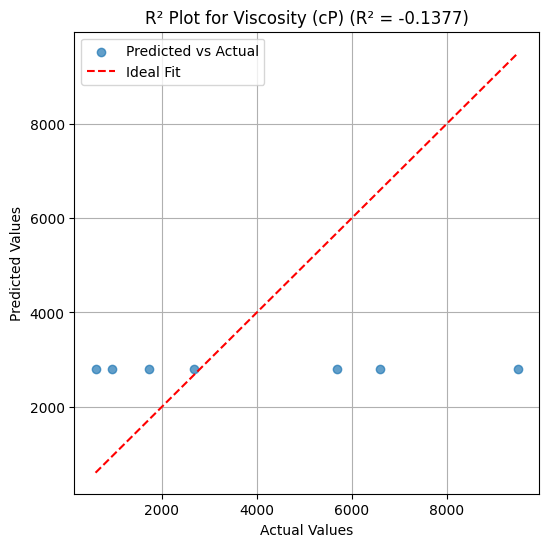

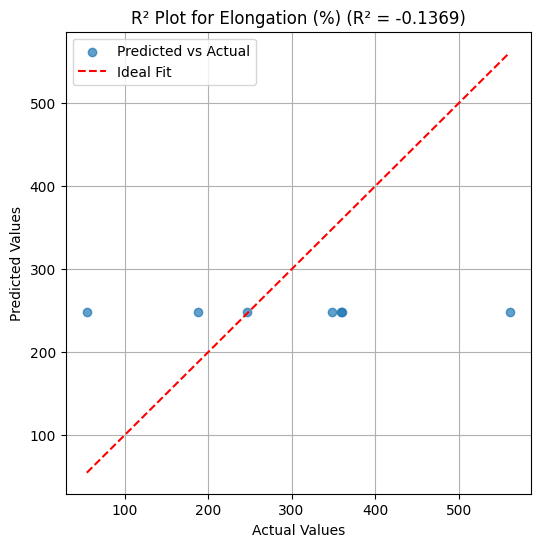

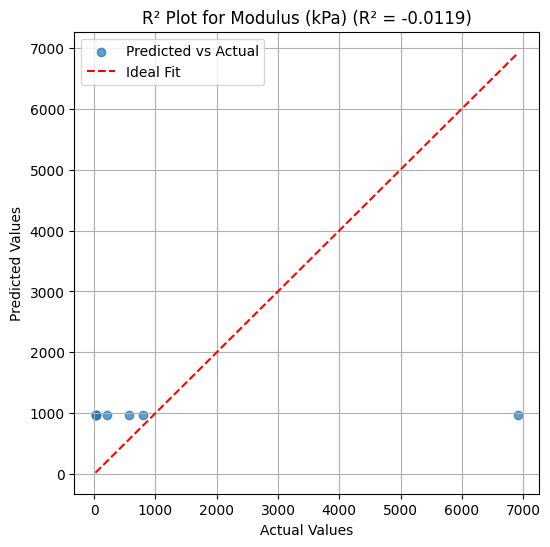

R² Scores for each output dimension:
Viscosity (cP): -0.1377
Elongation (%): -0.1369
Modulus (kPa): -0.0119


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Compute R² scores for each output
r2_scores = {}
for i, target_col in enumerate(Y.columns):
    r2_scores[target_col] = r2_score(Y_test.iloc[:, i], predictions[:, i])

# Generate R² plots for each output dimension
for i, target_col in enumerate(Y.columns):
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_test.iloc[:, i], predictions[:, i], alpha=0.7, label='Predicted vs Actual')
    plt.plot([min(Y_test.iloc[:, i]), max(Y_test.iloc[:, i])],
             [min(Y_test.iloc[:, i]), max(Y_test.iloc[:, i])],
             color='red', linestyle='--', label='Ideal Fit')
    plt.title(f'R² Plot for {target_col} (R² = {r2_scores[target_col]:.4f})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print R² scores for reference
print("R² Scores for each output dimension:")
for target, r2 in r2_scores.items():
    print(f"{target}: {r2:.4f}")
